In [1]:
import pandas as pnd
import numpy as nmp
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = pnd.read_table('dane2.dat', sep=' ')

## Zadanie 4
Przetestuj dostępne klasyfikatory przyjmując sensowną miarę jakości klasyfikacji. Znajdź najlepszy klasyfikator oraz (jeśli będzie to zasadne) podzbiór zbioru atrybutów, dla którego klasyfikacja jest najskuteczniejsza.

### Podział danych
Dzielimy zbiór danych na część treningową i testową w skoali 4:1.

In [2]:
cechy = ['atrybut1', 'atrybut2', 'atrybut3']
X3_train, X3_test, y3_train, y3_test = train_test_split(data[cechy], data['klasa'], test_size=0.2, random_state=1)

### Klasyfikator k-najbliższych sąsiadów
I sprawdzamy jak wygląda zależność prawdopodobnieństwa błędu od liczby sąsiadów, dla której wykonujemy klasyfikację.

Text(0,0.5,'Prawdopodobieństwo błedu')

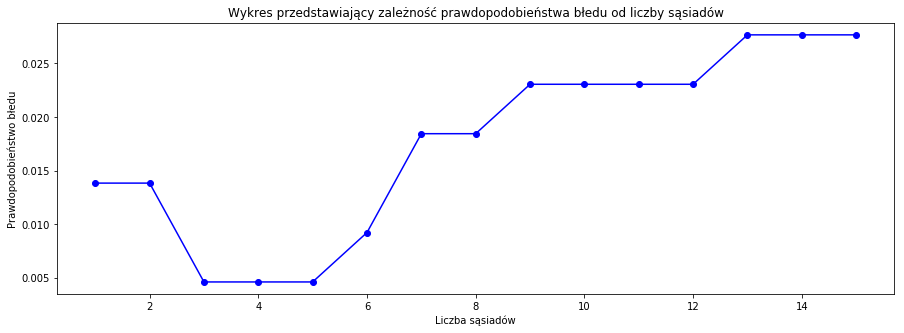

In [3]:
%matplotlib inline

k_range = range(1, 16)
results = nmp.zeros(len(k_range))

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X3_train,y3_train)
    predictions = model.predict(X3_test)
    results[k-1] = 1-model.score(X3_test,y3_test)
plt.figure(figsize=(15,5))
plt.plot(k_range, results,'bo-')
plt.title('Wykres przedstawiający zależność prawdopodobieństwa błedu od liczby sąsiadów')
plt.xlabel('Liczba sąsiadów')
plt.ylabel('Prawdopodobieństwo błedu')

Na wykresie wyraźnie widać, że najlepsze wyniki w danym przedziale można uzyskać dla liczby sąsiadów z przedziału [3, 5]. Wartość tą można też poznać korzystając z funkcji GridSearchCV.

In [4]:
cv = 5
numNeighbors = nmp.arange(2, 20)
param_grid = dict(n_neighbors = numNeighbors)
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv = cv) #pozmieniać zmienne
grid.fit(data[cechy], data['klasa'])

pnd.DataFrame(
    [[grid.best_params_['n_neighbors'], 1-grid.best_score_]],
    index = ["wartość"],
    columns = ["Liczba sąsiadów", "Średni błąd"]
)

,Liczba sąsiadów,Średni błąd
wartość,5,0.020295


Teraz można sprawdzić jakie parametry osiągnie klasyfikacja dla 5 sąsiadów.

In [8]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X3_train,y3_train)

knn_prediction = model.predict(X3_test) 

print(metrics.classification_report(y3_test, knn_prediction))

             precision    recall  f1-score   support

          A       1.00      0.98      0.99        48
          B       1.00      1.00      1.00        63
          C       1.00      1.00      1.00        67
          D       0.97      1.00      0.99        39

avg / total       1.00      1.00      1.00       217



### Naiwny klasyfikator Bayesa

In [9]:
gnb = GaussianNB()
y_pred = gnb.fit(X3_train, y3_train).predict(X3_test)
print("Błąd klasyfikacji:", 1-gnb.score(X3_test,y3_test))
print("Raport klasyfikacji: ")
print(metrics.classification_report(y3_test, y_pred))

Błąd klasyfikacji: 0.00460829493088
Raport klasyfikacji: 
             precision    recall  f1-score   support

          A       1.00      0.98      0.99        48
          B       1.00      1.00      1.00        63
          C       1.00      1.00      1.00        67
          D       0.97      1.00      0.99        39

avg / total       1.00      1.00      1.00       217



### Klasyfikator SVM

In [10]:
C = 1.0
svc = svm.SVC().fit(data[cechy], data.klasa).predict(X3_test)
#dec = svc.decision_function(data[cechy])
#dec.shape

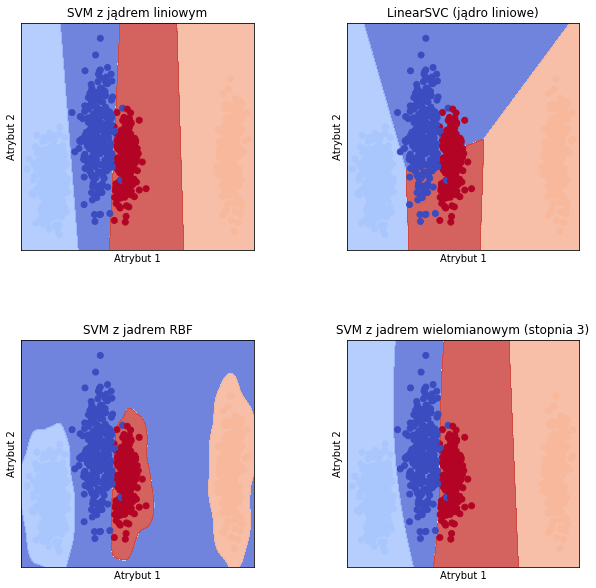

In [5]:
params = ["atrybut1", "atrybut2"]

def show_svm(params):
    h = .02

    classes = []
    translator = {
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
    }
    for c in data.klasa:
        classes.append(translator[c])

    svc = svm.SVC(kernel='linear', C=1.0).fit(data[params], classes)
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=1.0).fit(data[params], classes)
    poly_svc = svm.SVC(kernel='poly', degree=3, C=1.0).fit(data[params], classes)
    lin_svc = svm.LinearSVC(C=1.0).fit(data[params], classes)

    x_min = data[params].iloc[:, 0].min() - 1
    x_max = data[params].iloc[:, 0].max() + 1
    y_min = data[params].iloc[:, 1].min() - 1
    y_max = data[params].iloc[:, 1].max() + 1

    x_coord = nmp.arange(x_min, x_max, h) 
    y_coord = nmp.arange(y_min, y_max, h)
    x_mesh, y_mesh = nmp.meshgrid(x_coord, y_coord)

    titles = ['SVM z jądrem liniowym',
              'LinearSVC (jądro liniowe)',
              'SVM z jadrem RBF',
              'SVM z jadrem wielomianowym (stopnia 3)']

    plt.figure(figsize=(10,10))
    for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(nmp.c_[x_mesh.ravel(), y_mesh.ravel()])
        Z = Z.reshape(x_mesh.shape)
        plt.contourf(x_mesh, y_mesh, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(data[params].iloc[:, 0], data[params].iloc[:, 1], c=classes, cmap=plt.cm.coolwarm)
        plt.xlabel('Atrybut 1')
        plt.ylabel('Atrybut 2')
        plt.xlim(x_mesh.min(), x_mesh.max())
        plt.ylim(y_mesh.min(), y_mesh.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()

show_svm(params)

In [ ]:
show_svm(["atrybut2", "atrybut3"])